1\. **2D minimization of a six-hump camelback function**

$$f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2$$

has multiple global and local minima.

- Find the global minima of this function
- How many global minima are there, and what is the function value at those points?
- What happens for an initial guess of $(x, y) = (0, 0)$?

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use `numpy.meshgrid()` and `pylab.imshow()` to find visually the regions.
* Use `scipy.optimize.minimize()`, optionally trying its optional arguments.

In [16]:
import numpy as np
from scipy import stats
from scipy.integrate import trapz
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

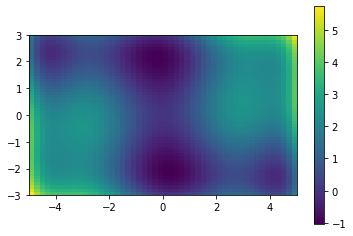

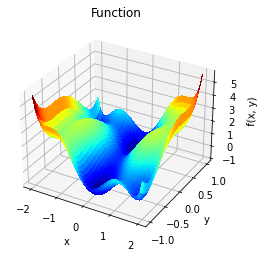

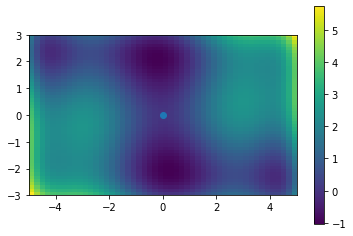

In [11]:
def F(x):
    return ((4 - 2.1*x[0]**2 + x[0]**4 / 3) * x[0]**2 + x[0] * x[1] + (-4 + 4*x[1]**2) * x[1] **2)

x = np.linspace(-2, 2)
y = np.linspace(-1, 1)
xg, yg = np.meshgrid(x, y)

import matplotlib.pyplot as plt
plt.figure()
plt.imshow(F([xg, yg]), extent=[-5, 5, -3, 3], origin="lower")
plt.colorbar()

from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(xg, yg, F([xg, yg]), rstride=1, cstride=1, cmap=plt.cm.jet, linewidth=0, antialiased=False)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('Function')

from scipy import optimize

x_min = optimize.minimize(F, x0=[0, 0])

plt.figure()
plt.imshow(F([xg, yg]), extent=[-5, 5, -3, 3], origin="lower")
plt.colorbar()
plt.scatter(x_min.x[0], x_min.x[1])

plt.show()

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  `17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18`

min: `-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58`

* Plot these temperatures.
* Find a suitable a function that can describe min and max temperatures. 
* Fit this function to the data with `scipy.optimize.curve_fit()`.
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

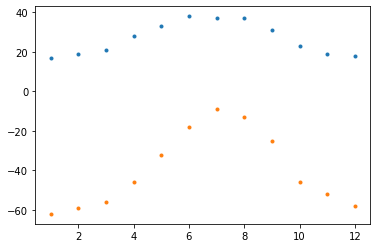

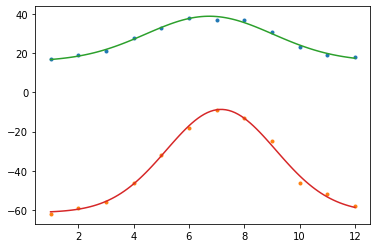

Compatibility is:  4.6381194188715


In [20]:
from scipy.interpolate import UnivariateSpline
import scipy.optimize
from scipy import optimize, stats

month = [i for i in range(1,13)]
max_temp = [17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18]
min_temp = [-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58]

fig, ax =plt.subplots()
plt.plot(month, max_temp,'.')
plt.plot(month, min_temp,'.')
plt.show()

def gauss(x, mu, sig, ampl, offset):
    return offset + ampl * stats.norm.pdf(x,mu,sig)

par_max, cov_max = scipy.optimize.curve_fit(gauss, month, max_temp, p0=[7,1,20,10])
par_min, cov_min = scipy.optimize.curve_fit(gauss, month, min_temp, p0=[7,1,0,-60])

cont_func = np.linspace(1,12,100)
plt.plot(month, max_temp,'.')
plt.plot(month, min_temp,'.')
plt.plot(cont_func, gauss(cont_func,par_max[0],par_max[1],par_max[2],par_max[3]))
plt.plot(cont_func, gauss(cont_func,par_min[0],par_min[1],par_min[2],par_min[3]))
plt.show()

t_min = par_min[0]
t_max = par_max[0]
var_min = cov_min[0][0]
var_max = cov_max[0][0]

print("Compatibility is: ", np.abs(par_min[0]-par_max[0])/np.sqrt(cov_min[0][0]+cov_max[0][0]))

3\. **Fit the residues**

Read the `data/residuals_261.pkl` file. If you haven't it already, download it from here:

```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```

The feature name "residual" contains the residuals (defined as $y_i - \hat{y}_i$) of a linear regression as a function of the independent variable "distances".

- Considering only the "residual" feature, create an histogram with the appropriate binning and display it.
- Set the appropriate Poisson uncertainty for each bin (thus, for each bin, $\sigma_i = \sqrt{n_i}$, where $n_i$ is the number of entries in each bin)
- By looking at the distribution of the residuals, define an appropriate function and fit it to the histogram of the residuals
- Perform a goodness-of-fit test. Is the p-value of the fit satisfactory?

No handles with labels found to put in legend.


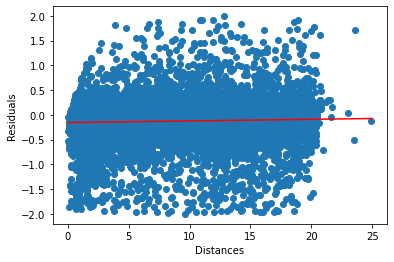

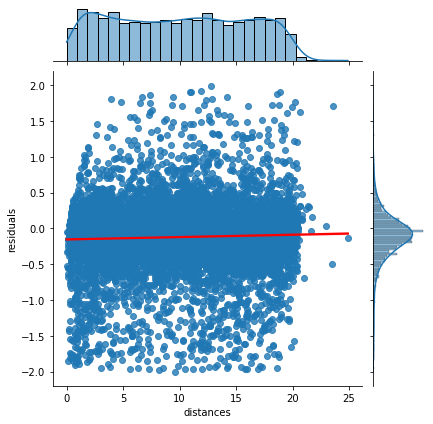

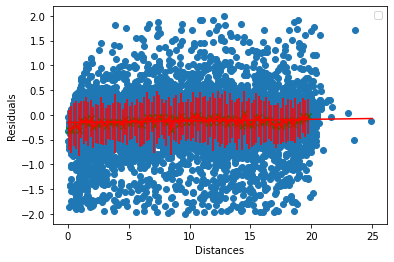

In [13]:
import pandas as pd
import seaborn as sns

data = pd.DataFrame(np.load('residuals_261.pkl',allow_pickle=True).item())
data = data[np.abs(data['residuals'])<2]

slope, intercept, _, _, _ = stats.linregress(data['distances'],data['residuals'])
plt.scatter( data['distances'],data['residuals'])
plt.xlabel('Distances')
plt.ylabel('Residuals')
plt.plot(np.linspace(0,25,100), intercept+slope*np.linspace(0,25,100),color='r')

sns.jointplot(x='distances', y='residuals', data = data, kind = 'reg', joint_kws={'line_kws':{'color':'red'}})
plt.xlabel('Distances')
plt.ylabel('Residuals')

x = np.arange(0,20, 20/100)
bins = (x[1:]+x[:-1])/2
y = [ np.array(data['residuals'][ (data['distances']< x[i+1]) & (data['distances']> x[i])  ]).mean() for i in range(len(x)-1)]
erry = [ np.array(data['residuals'][ (data['distances']< x[i+1]) & (data['distances']> x[i]) ]).std() for i in range(len(x)-1)]

fig, ax = plt.subplots()
ax.scatter(data['distances'],data['residuals'])
plt.plot(np.linspace(0,25,100), intercept+slope*np.linspace(0,25,100),color='red')
ax.scatter(bins,y,marker = 'x',color='green')
ax.errorbar(bins,y,erry,color='red')
ax.set_xlabel('Distances')
ax.set_ylabel('Residuals')
ax.legend()

4\. **Temperatures in Munich**

Get the following data file:

```bash
https://www.dropbox.com/s/7gy9yjl00ymxb8h/munich_temperatures_average_with_bad_data.txt
```

which gives the temperature in Munich every day for several years.


Fit the following function to the data:

$$f(t) = a \cos(2\pi t + b)+c$$

where $t$ is the time in years.

- Make a plot of the data and the best-fit model in the range 2008 to 2012.

   - What are the best-fit values of the parameters?

   - What is the overall average temperature in Munich, and what are the typical daily average values predicted by the model for the coldest and hottest time of year?

   - What is the meaning of the $b$ parameter, and what physical sense does it have?


- Now fit the data with the function $g(x)$, which has 1 more parameter than $f(x)$.
$$g(x) = a \cos(2\pi b t + c)+d$$
   - What are the RSS for $f(x)$ and $g(x)$?
   - Use the Fisher F-test to determine whether the additional parameter is motivated.

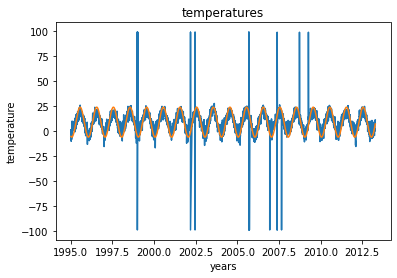

15 2.8 8.941907038598593
23.941394135329666
-6.058047035057573


In [7]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
 
x, y = np.loadtxt(open('munich_temperatures_average_with_bad_data.txt'), unpack = True)

a = 15
b = 2.8
c = np.mean(y)

p0 = [a,b,c]

def F(x, a, b, c):
    return a*np.cos(2*np.pi*x+b)+c
    
fit = curve_fit(F, x, y, p0=p0)
First_guess = F(x, *p0)

ymax = max(First_guess)
ymin = min(First_guess)



plt.plot(x, y)
plt.plot(x, First_guess)
plt.xlabel('years')
plt.ylabel('temperature')
plt.title('temperatures')
plt.show()
print (a, b, c)
print (ymax)
print(ymin)